In [1]:
import os
import glob
import random
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
import librosa
from sklearn. preprocessing import LabelEncoder
from tensorflow. keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow. keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Path to the dataset containing directories of MP3 files
dataset_path = 'E:\MS Data Science\SIT 782 Capstone Team Project B\Bucket Data 2'  

# Gather all MP3 files from the dataset
all_files = glob.glob(os.path.join(dataset_path, '*/*.mp3'))

# Split the files into training (80%), validation (10%), and test (10%)
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

print(f"Total files: {len(all_files)}")
print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Testing files: {len(test_files)}")

Total files: 2123
Training files: 1698
Validation files: 212
Testing files: 213


In [3]:
def preprocess_audio(dataset_path, target_length=22050):  
    # Load an audio file as a floating point time series.
    audio, sr = librosa.load(dataset_path, sr=None, mono=True)
    
    # Resample to 22050 Hz
    if sr != 22050:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=22050)
    
    # Trim or pad the audio signal to a fixed length
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        audio = np.pad(audio, (0, max(0, target_length - len(audio))), "constant")
    
    # Normalize the audio to [-1, 1]
    audio = audio / np.max(np.abs(audio))
    
    return audio.reshape(target_length,1)  # Reshape for the model

In [4]:
def SoundNet(input_shape=(22050, 1), num_classes=33):
    sound_input = Input(shape=input_shape)
    
    # First block
    x = Conv1D(16, 64, strides=2, padding='same', name='conv1')(sound_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    x = MaxPooling1D(pool_size=8, strides=8, name='maxpool1')(x)

    # Second block
    x = Conv1D(32, 32, strides=2, padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu', name='relu2')(x)
    x = MaxPooling1D(pool_size=8, strides=8, name='maxpool2')(x)

    # Third block
    x = Conv1D(64, 16, strides=2, padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu', name='relu3')(x)

    # Fourth block
    x = Conv1D(128, 8, strides=2, padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu', name='relu4')(x)

    # Fifth block
    x = Conv1D(256, 4, strides=2, padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu', name='relu5')(x)

    # Sixth block
    x = Conv1D(512, 4, strides=2, padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu', name='relu6')(x)
    x = MaxPooling1D(pool_size=4, strides=4, name='maxpool6')(x)

    # Seventh block
    x = Conv1D(1024, 4, strides=2, padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu', name='relu7')(x)

    # Adding a global average pooling layer to reduce dimensions and flatten the output
    x = GlobalAveragePooling1D(name='gap')(x)

    # Fully connected layer with 1024 units and ReLU activation
    x = Dense(1024, activation='relu', name='fc1')(x)

    # Output layer with softmax activation for classification
    predictions = Dense(num_classes, activation='softmax', name='output')(x)

    # Create the model
    model = Model(inputs=sound_input, outputs=predictions)
    return model

# Instantiate the model
soundnet_model = SoundNet(input_shape=(22050, 1), num_classes=33)

# Compile the model with Adam optimizer and categorical crossentropy loss
soundnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the architecture
soundnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 22050, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv1D)                  │ (None, 11025, 16)      │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 11025, 16)      │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 11025, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling1D)         │ (None, 1378, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 689, 32)        │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 689, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 689, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling1D)         │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 43, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 43, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv1D)                  │ (None, 22, 128)        │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 22, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu4 (Activation)              │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv1D)                  │ (None, 11, 256)        │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 11, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu5 (Activation)              │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv1D)                  │ (None, 6, 512)         │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 6, 512)         │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu6 (Activation)              │ (None, 6, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool6 (MaxPooling1D)         │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv1D)                  │ (None, 1, 1024)        │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn7 (BatchNormalization)        │ (None, 1, 1024)        │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu7 (Activation)              │ (None, 1, 1024)        │             

 Total params: 3,961,809 (15.11 MB)

 Trainable params: 3,957,745 (15.10 MB)

 Non-trainable params: 4,064 (15.88 KB)

In [5]:
# Open the file in the correct mode and load the weights with the 'latin1' encoding
with open('sound8.npy', 'rb') as f:
    weights_dict = np.load(f, allow_pickle=True, encoding='latin1').item()
# Print the keys and shapes of the weights to understand their structure
for key in weights_dict.keys():
    print(f"Layer Name: {key}")
    for subkey in weights_dict[key].keys():
        print(f"  {subkey}: {weights_dict[key][subkey].shape}")

Layer Name: conv3
  beta: (64,)
  weights: (16, 1, 32, 64)
  biases: (64,)
  var: (64,)
  gamma: (64,)
  mean: (64,)
Layer Name: conv2
  beta: (32,)
  weights: (32, 1, 16, 32)
  biases: (32,)
  var: (32,)
  gamma: (32,)
  mean: (32,)
Layer Name: conv1
  beta: (16,)
  weights: (64, 1, 1, 16)
  biases: (16,)
  var: (16,)
  gamma: (16,)
  mean: (16,)
Layer Name: conv7
  beta: (1024,)
  weights: (4, 1, 512, 1024)
  biases: (1024,)
  var: (1024,)
  gamma: (1024,)
  mean: (1024,)
Layer Name: conv6
  beta: (512,)
  weights: (4, 1, 256, 512)
  biases: (512,)
  var: (512,)
  gamma: (512,)
  mean: (512,)
Layer Name: conv5
  beta: (256,)
  weights: (4, 1, 128, 256)
  biases: (256,)
  var: (256,)
  gamma: (256,)
  mean: (256,)
Layer Name: conv4
  beta: (128,)
  weights: (8, 1, 64, 128)
  biases: (128,)
  var: (128,)
  gamma: (128,)
  mean: (128,)
Layer Name: conv8_2
  weights: (8, 1, 1024, 401)
  biases: (401,)
Layer Name: conv8
  weights: (8, 1, 1024, 1000)
  biases: (1000,)


In [6]:
def load_pretrained_weights(model, weight_path):
    # Load the weights with the 'latin1' encoding
    weights_dict = np.load(weight_path, allow_pickle=True, encoding='latin1').item()

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv1D):
            # Extract the layer number from the layer name
            layer_num = int(''.join(filter(str.isdigit, layer.name)))
            weight_key = f'conv{layer_num}'
            print(f"Checking for weights for layer: {layer.name} with key: {weight_key}")

            if weight_key in weights_dict:
                # Extract the weights and biases
                W, b = weights_dict[weight_key]['weights'], weights_dict[weight_key]['biases']
                print(f"Loaded weights shape before reshape: {W.shape}, biases shape: {b.shape}")

                # Conv1D layers expect weights with shape (filter_length, input_channels, output_channels)
                W = np.reshape(W, newshape=(W.shape[0], W.shape[2], W.shape[3]))
                print(f"Loaded weights shape after reshape: {W.shape}")

                # Set the weights for the layer
                layer.set_weights([W, b])
                print(f"Weights loaded for layer: {layer.name}")
            else:
                print(f"No weights found for layer: {layer.name}")

# Load the pretrained weights into the model
load_pretrained_weights(soundnet_model, 'sound8.npy')

Checking for weights for layer: conv1 with key: conv1
Loaded weights shape before reshape: (64, 1, 1, 16), biases shape: (16,)
Loaded weights shape after reshape: (64, 1, 16)
Weights loaded for layer: conv1
Checking for weights for layer: conv2 with key: conv2
Loaded weights shape before reshape: (32, 1, 16, 32), biases shape: (32,)
Loaded weights shape after reshape: (32, 16, 32)
Weights loaded for layer: conv2
Checking for weights for layer: conv3 with key: conv3
Loaded weights shape before reshape: (16, 1, 32, 64), biases shape: (64,)
Loaded weights shape after reshape: (16, 32, 64)
Weights loaded for layer: conv3
Checking for weights for layer: conv4 with key: conv4
Loaded weights shape before reshape: (8, 1, 64, 128), biases shape: (128,)
Loaded weights shape after reshape: (8, 64, 128)
Weights loaded for layer: conv4
Checking for weights for layer: conv5 with key: conv5
Loaded weights shape before reshape: (4, 1, 128, 256), biases shape: (256,)
Loaded weights shape after reshape:

In [7]:
def encode_labels(labels):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    onehot_encoded = to_categorical(integer_encoded)
    return onehot_encoded, label_encoder

In [8]:
# Extract labels from the file path
def extract_label(dataset_path):
    return os.path.basename(os.path.dirname(dataset_path))

# List of all file paths
all_file_paths = ['Acanthiza chrysorrhoa',
 'Acanthiza lineata',
 'Acanthiza nana',
 'Acanthiza pusilla',
 'Acanthiza reguloides',
 'Acanthiza uropygialis',
 'Acanthorhynchus tenuirostris',
 'Accipiter cirrocephalus',
 'Aidemosyne modesta',
 'Alauda arvensis',
 'Anhinga novaehollandiae',
 'Anthochaera phrygia',
 'Antigone rubicunda',
 'Artamus cinereus',
 'Artamus cyanopterus',
 'Artamus minor',
 'Artamus superciliosus',
 'Barnardius zonarius',
 'Callocephalon fimbriatum',
 'Calyptorhynchus banksii',
 'Calyptorhynchus lathami',
 'Capra Hircus',
 'Carduelis carduelis',
 'Carterornis leucotis',
 'Cervus Unicolour',
 'Chenonetta jubata',
 'Chlamydera nuchalis',
 'Cincloramphus mathewsi',
 'Cinclosoma punctatum',
 'Cisticola exilis',
 'Climacteris picumnus',
 'Colluricincla harmonica','Ceyx azureus']  # replace with actual list of file paths

# Extract labels for all data
all_labels = [extract_label(fp) for fp in all_file_paths]

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit the label encoder on all labels
label_encoder.fit(all_labels)

# Load and preprocess the data
X_train = np.array([preprocess_audio(fp) for fp in train_files])
X_val = np.array([preprocess_audio(fp) for fp in val_files])
X_test = np.array([preprocess_audio(fp) for fp in test_files])

# Extract labels for each set
Y_train_labels = np.array([extract_label(fp) for fp in train_files])
Y_val_labels = np.array([extract_label(fp) for fp in val_files])
Y_test_labels = np.array([extract_label(fp) for fp in test_files])

# Encode labels
label_encoder = LabelEncoder()
Y_train_encoded = to_categorical(label_encoder.fit_transform(Y_train_labels))
Y_val_encoded = to_categorical(label_encoder.transform(Y_val_labels))
Y_test_encoded = to_categorical(label_encoder.transform(Y_test_labels))

In [9]:
# Assuming soundnet_model is the model instance you've created and compiled earlier.

# Define your callbacks (for example, early stopping to prevent overfitting)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = soundnet_model.fit(
    X_train, Y_train_encoded,
    epochs=50,  # You can change the number of epochs
    batch_size=32,  # And the batch size
    validation_data=(X_val, Y_val_encoded),
    callbacks=[early_stopping]
)

# Save the trained model
soundnet_model.save('soundnet_trained_model.h5')

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.1596 - loss: 3.0800 - val_accuracy: 0.0330 - val_loss: 5.1038
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.3989 - loss: 2.1575 - val_accuracy: 0.1887 - val_loss: 2.8123
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.4603 - loss: 1.7942 - val_accuracy: 0.4151 - val_loss: 2.0545
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.5497 - loss: 1.5035 - val_accuracy: 0.5047 - val_loss: 1.7355
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.6379 - loss: 1.2084 - val_accuracy: 0.5708 - val_loss: 1.4742
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.6658 - loss: 1.0800 - val_accuracy: 0.5519 - val_loss: 1.3909
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.6412 - loss: 1.1250 - val_accuracy: 0.6321 - val_loss: 1.2958
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.6671 - loss: 1.1235 - val_accuracy: 0.6462 

In [10]:
# Evaluate the model
test_loss, test_accuracy = soundnet_model.evaluate(X_test, Y_test_encoded)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7345 - loss: 1.2226
Test loss: 1.2806743383407593, Test accuracy: 0.7323943376541138


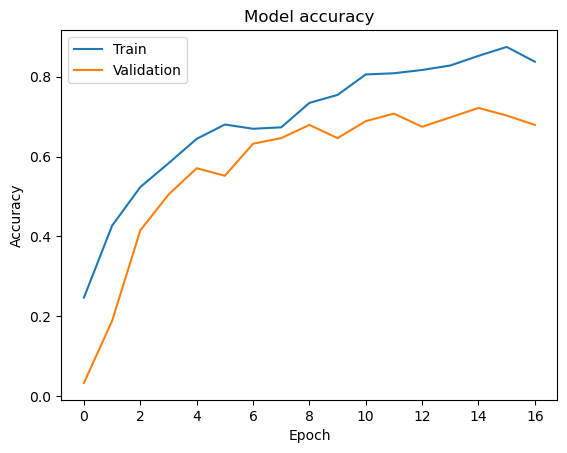

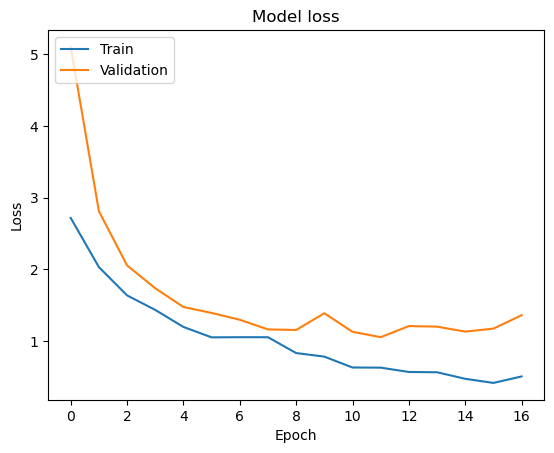

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
                              precision    recall  f1-score   support

       Acanthiza chrysorrhoa       0.67      1.00      0.80         2
           Acanthiza lineata       0.00      0.00      0.00         2
              Acanthiza nana       1.00      0.85      0.92        13
           Acanthiza pusilla       0.55      0.64      0.59        25
        Acanthiza reguloides       1.00      0.76      0.87        17
       Acanthiza uropygialis       0.83      0.62      0.71         8
Acanthorhynchus tenuirostris       0.38      0.50      0.43         6
     Accipiter cirrocephalus       0.56      0.56      0.56         9
          Aidemosyne modesta       1.00      1.00      1.00         1
         Anthochaera phrygia       0.00      0.00      0.00         2
          Antigone rubicunda       1.00      0.67      0.80         3
            Artamus cinereus       1.00      0.50      0.67         2
         Artamus cyanopterus       0.60      1.00  

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


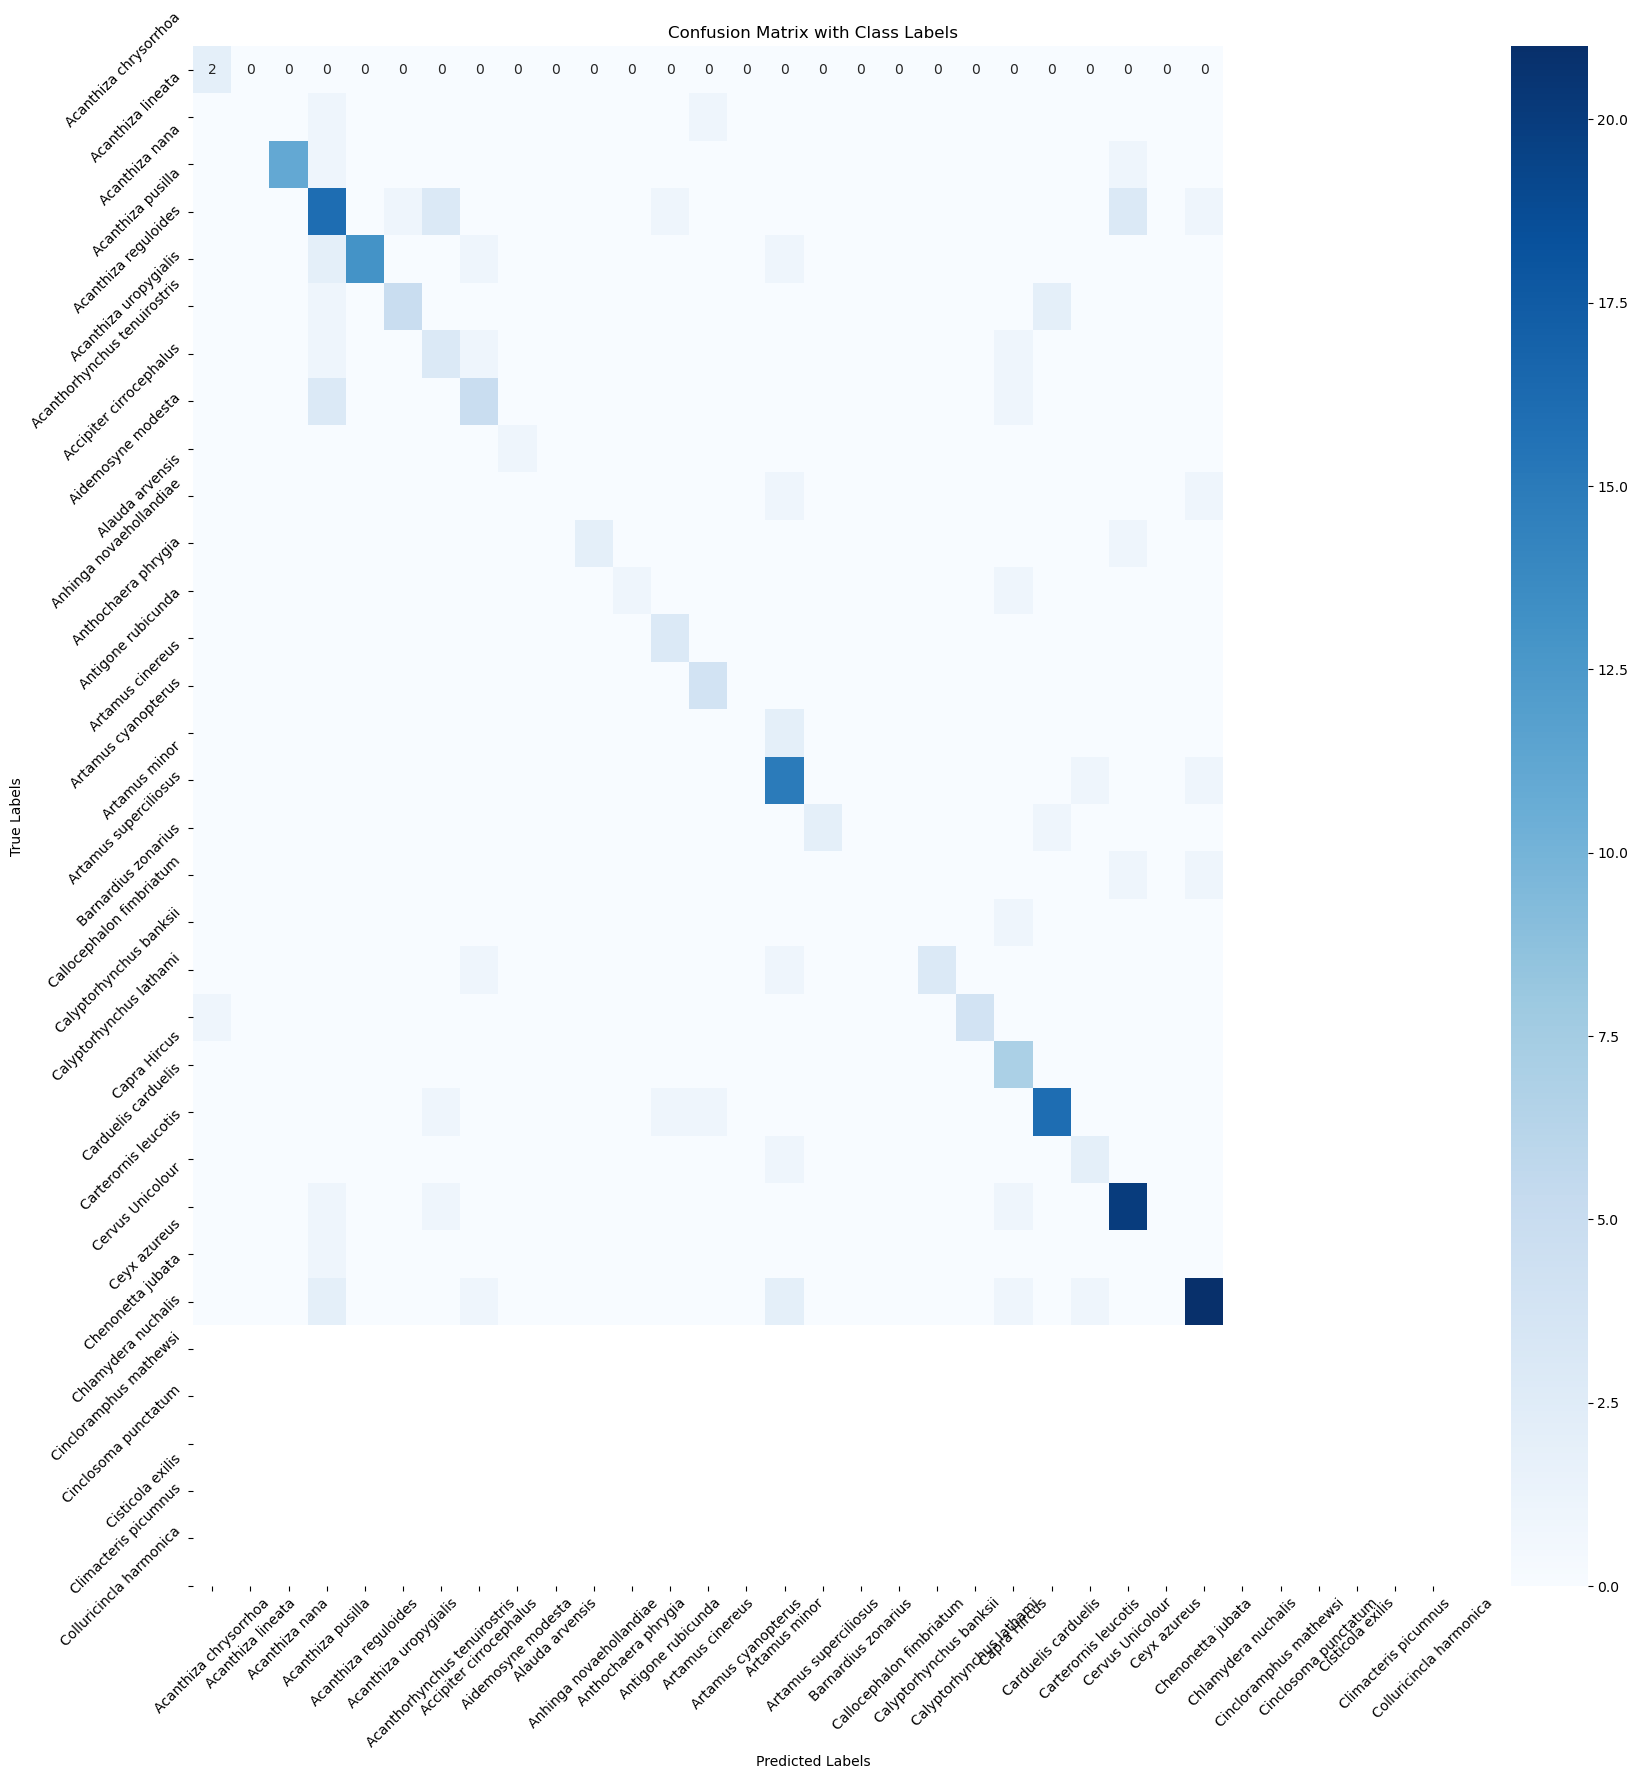

In [12]:
predicted_probabilities = soundnet_model.predict(X_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# convert it back to label encoding
actual_classes = np.argmax(Y_test_encoded, axis=1)

# Convert encoded labels back to original labels
actual_labels = label_encoder.inverse_transform(actual_classes)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Generating a classification report with labels
class_report = classification_report(actual_labels, predicted_labels)
print(class_report)

# Generating a confusion matrix
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

# Plotting the confusion matrix with class names
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix with Class Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
